## Imports

In [17]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import random

import umap

import time


from matplotlib import cm
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding


# import seaborn as sns
# import pandas as pd

### Room Dimensions

In [18]:
# room dimensions in cm (very sophisticated)
width = 140
height = 140

## Number of cells

In [19]:
# number of simulated place cells
n_cells = 20

## Borrowed code

In [20]:
## Neuromatch academy code
# I don't think I use this, however

def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  cmap = plt.cm.get_cmap('tab10')
  plt.scatter(x=component1, y=component2, c=labels, cmap=cmap)
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

## Place cell class

In [21]:
# place cell class

class PlaceCell(object):
    '''
    bivariate Gaussian + Poisson random process for modelling plae cell activity

    Args:
        mu: 2d Gaussian mean (2x1) - location of activity peak
        sigma: covariance matrix (2x2)
    Returns:
        Place cell object with peak activity at arbitrary location, generates number of spikes per timebin
    '''
    def __init__(self, mu, sigma):
        '''
        takes in two variables
        mu = 2x1 vector - means of x1 and x2, location at which the cell is most active 
        sigma = 2x2 matrix = covariance matrix...
        '''
        self.mu = mu
        self.sigma = sigma
        
        
    # look for library function
    def gaussian(self, x):
        '''
        input: x = 2x1 array. room location at which activity for a given cell is calculated
        output: bivariate Gaussian result in (1, 1) np.array shape
        '''
        # k = number of dimensions
        k = self.sigma.ndim
        xm = x - self.mu
        sigma = self.sigma
        
        # bivariate Gaussian split into two factors

        # factor1 = ((2*np.pi)**(-k/2)) * np.linalg.det(sigma)**(-1/2) # normalization -- (turn into a number), peak firing rate
        factor1 = 10            # peak firing rate/ amplitude
        factor2 = np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm)  # multiply factor2 with amplitude
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        '''
        utilizes poisson random process
        
        will return spike count per time bin
        '''     
        activity = np.random.poisson(self.gaussian(x))
        return activity
        
        

## Generating and plotting place cells

### Test cell

In [22]:
# test cell

testMu = np.array([[70],    #width
                   [70]])   #height

testSigma = np.array([[80, 0],
                      [0, 80]])

testCell = PlaceCell(testMu, testSigma)

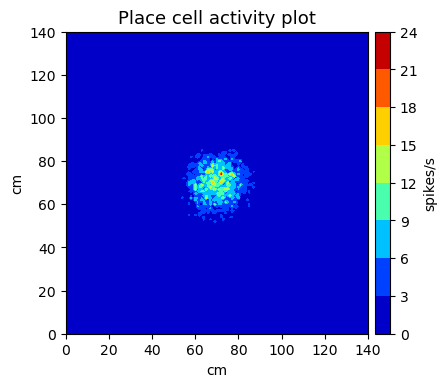

In [23]:
### plotting testCell ###

def plotTestCell(height = height, width = width):
    '''
    plotting test cell
    Args:
    Returns:
    '''
    # indicies are swapping based on what I'm plotting

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen = len(x_coordinates)
    yLen = len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')       # look again at the np.meshgrid function
    Z = np.zeros((yLen, xLen))
    # Z = []    # look at this kind of solution again, it can make it run faster

    for y in range(yLen):
        for x in range(xLen):
            
            element = np.array([[x_coordinates[x]],                         # important to be careful about the indexing
                                [y_coordinates[y]]])

            result = testCell.activity(element)
            
            Z[y][x] = result

    ### check the code step by step again. This can also be very lieky done much better. Maybe discuss with someone

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')     # vmin=0, vmax=20
    plt.colorbar(label = 'spikes/s', pad = -0.17)    
    plt.title("Place cell activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')

    plt.show()
    
    pass
    
# np.random.seed(10)
plotTestCell(height, width)

### Place Cells list

In [24]:
def generatePlaceCells(n_cells, sigma, height = height, width = width):
    '''
    function that generates N PlaceCell class objects
    assigns random location of activity to each cell
    Input: n_cells: number of cells to generate, width, height sigma: covariance matrix
    Output: N randomly distributed place cells
    '''

    #place cells list init
    cellsList = []
    
    for i in range(n_cells):
        
        # mu being location at which the cell is most active 
        mu = np.array([[random.uniform(0,width)],       # width
                       [random.uniform(0,height)]])     # height
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [25]:
# generating cells list

sigma = np.array([[80, 0],
                  [0, 80]])

random.seed(10)
cellsList = generatePlaceCells(n_cells, sigma, height, width)

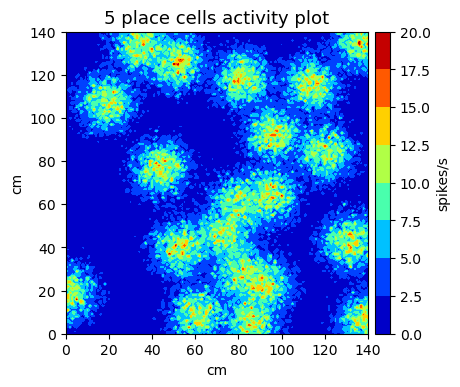

In [26]:
def plotCells(cellsList = cellsList, height = height, width = width):
    '''
    plotting cells list
    Args:
    Returns:
    '''
    # indicies are swapping based on what I'm plotting

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen = len(x_coordinates)
    yLen = len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            
            location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
                                 [y_coordinates[y]]])
            
            for placeCell in cellsList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    ### check the code step by step again. This can also be very lieky done much better. Maybe discuss with someone

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/s', pad = -0.17)
    plt.title("5 place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    
    pass

# np.random.seed(10)
plotCells()


### Colormapping

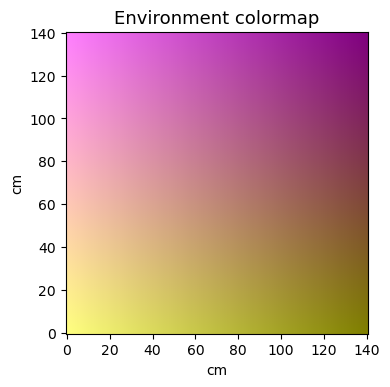

In [27]:
def colormapLocation(coordinates, height = height, width = width):
    '''
    turning coordinates into a color, each 2d coordinate has a unique color
    Args:
    Returns:
    '''
    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX = normalizeX(coordinates[0,:])
    normY = normalizeY(coordinates[1,:])

    # mapX = cm.get_cmap('Blues')
    # mapY = cm.get_cmap('Reds')

    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)

    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

def colormapEnvironment(height = height, width = width):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen = len(x_coordinates)
    yLen = len(y_coordinates)

    dataLocation = []

    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height

            dataLocation.append(location)

    colormap = colormapLocation(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)       ### I am very confused by the orther of the dimensions now

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    ## Run the code without the ticks. It then chooses strange numbers for x-axis. There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")

    plt.show()
    pass

colormapEnvironment()

# Generating data

### All-knowing mouse function (MasterMouse)

In [28]:
def masterMouse(cellsList, nSteps=1, height = height, width = width):
    '''
    A mouse that has been everywhere and seen everything
    '''
    # nSteps not used
    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    data = []
    dataLocation = []
    
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            # dataLocation.append(location)
            dataLocation.append(np.copy(location))

            sample = []
            for placeCell in cellsList:
                sample.append(placeCell.activity(location))
            data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)

    return (data, dataLocation)

### Randomly teleporting mouse function (RandomMouse)

In [29]:
# 20 variables(neurons), n smaples(nSteps)

def randomMouse(cellsList, nSteps, height = height, width = width):
    '''
    '''
    data = []
    dataLocation = []
    
    for step in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        # dataLocation.append(location)
        dataLocation.append(np.copy(location))

        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))
        
    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
        
    return (data, dataLocation)


## Realistic movement (somewhat)

In [31]:
def generateSpikes(cellsList, coordinates):
    '''
    '''
    coordinates = np.hsplit(coordinates,len(coordinates[0,:]))
    data = []
    for location in coordinates:
        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    
    return(data)

In [30]:
def drunkMouse(nSteps, height = height, width = width):
    '''
    '''

    cm = 1
    movements = [np.array([[cm],[0]]), np.array([[-cm],[0]]), np.array([[0],[cm]]), np.array([[0],[-cm]])]

    dataLocation = []
    location = np.array([[width /2],        # first location is the middle of the environment
                         [height /2]])


    for step in range(nSteps):
        dataLocation.append(np.copy(location))      # append(location) was clearly mistake but how about append(location[:,:])
        nextMove = random.choice(movements)
        location += nextMove
        
        while (location[0,0] < 0 or location[0,0] > width) or (location[1,0] < 0 or location[1,0] > height):
            location -= nextMove
            nextMove = random.choice(movements)
            location += nextMove

    return np.hstack(dataLocation)

drunkMouseLocation = drunkMouse(nSteps = 10000)


    

In [32]:
drunkWalkSpikes = generateSpikes(cellsList,drunkMouseLocation)
drunkWalkSpikes.shape

array([[1, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 5, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0]])

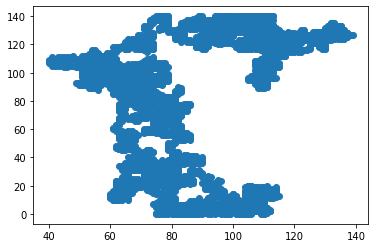

In [33]:
plt.scatter(drunkMouseLocation[0,:], drunkMouseLocation[1,:])

### Generating Data

In [34]:
# np.random.seed(10)      #does this even make sense?

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32)

(masterMouseData, masterMouseDataLocation) = masterMouse(cellsList, height, width)

In [35]:
print("masterMouseData shape is " + str(masterMouseData.shape))
print("masterMouseDataLocation shape is " + str(masterMouseDataLocation.shape))
masterMouseData
masterMouseDataLocation

masterMouseData shape is (19881, 20)
masterMouseDataLocation shape is (2, 19881)


array([[  0,   1,   2, ..., 138, 139, 140],
       [  0,   0,   0, ..., 140, 140, 140]])

In [36]:
# np.random.seed(10)      # I think that if I set this seed then locations are not random (as planned), but also poisson random process is not random.

t = 1000 * time.time() # current time in milliseconds
np.random.seed(int(t) % 2**32) # I do this to reset the seed (if set), so it does not affect the Poisson random process

(randomMouseData, randomMouseDataLocation) = randomMouse(cellsList, 141*141, height, width)         # SyntaxError: positional argument follows keyword argument
# (randomMouseData, randomMouseDataLocation) = randomMouse( cellsList, 100000, height, width)  # rethink the number of trials

In [37]:
print("randomMouseData shape is " + str(randomMouseData.shape))
print("randomMouseDataLocation is " + str(randomMouseDataLocation.shape))

randomMouseData shape is (19881, 20)
randomMouseDataLocation is (2, 19881)


## Generating trials

In [38]:
## adding master trials into 3D array

def collectTrials(dataGenerator, numTrials, nSteps= 1):

    dataList = []
    locationList = []
    for trial in range(numTrials):
        (data, location) = dataGenerator(cellsList, nSteps, height, width)

        dataList.append(data)
        locationList.append(location)

    trialsData = np.stack(dataList)
    trialsLocation = np.stack(locationList)

    return trialsData, trialsLocation


In [39]:
# trials master mouse
trialsData, trialsLocation = collectTrials(masterMouse, 10)

print(trialsData.shape)
print(trialsLocation.shape)

(10, 19881, 20)
(10, 2, 19881)


In [40]:
# trials random mouse
trialsData, trialsLocation = collectTrials(randomMouse, 10, 20000)

print(trialsData.shape)
print(trialsLocation.shape)

(10, 20000, 20)
(10, 2, 20000)


# MasterMouse data exploration

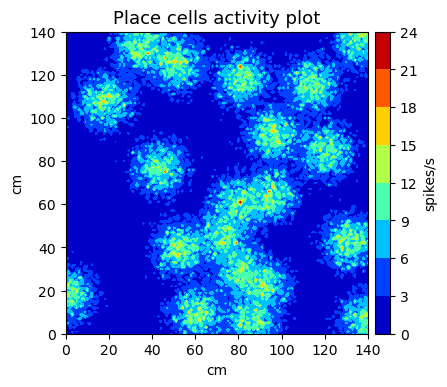

In [59]:
# Plotting ordered data function

def plotOrderedData(data, height = height, width = width):
    '''
    '''
    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    xLen = len(x_coordinates)
    yLen = len(y_coordinates)

    Z = data[:, 0]

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')

    for index in range(data.shape[1]):
        Z = np.maximum(Z, data[:, index])

    Z = Z.reshape(len(x_coordinates),len(y_coordinates))

    plt.figure(dpi=100)    # figsize=(width, height)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/s', pad = -0.17)
    # plt.clim(0,20)
    plt.title("Place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    
    pass

plotOrderedData(masterMouseData)

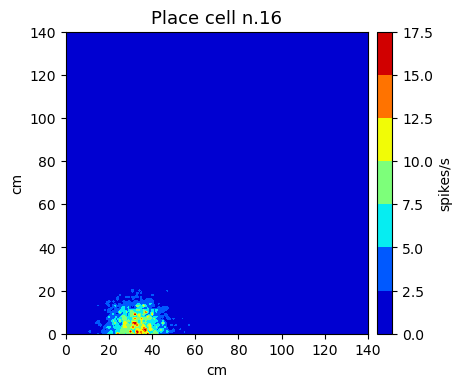

In [32]:
# Turning master mouse data into room plot

def plotDataCell(data, index=0, title = "title", units = "units", colorbarLabel = "colorbarLabel"):
    '''
    '''
    cell = data[:,index]

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')

    Z = cell.reshape(len(x_coordinates),len(y_coordinates))


    plt.figure(dpi=100)    # figsize=(width, height)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = colorbarLabel, pad = -0.16)
    # plt.clim(0,20)                                                                     # I have to look into these numbers again when I have more plausible models
    plt.title(title, size = 13)
    plt.xlabel(units)
    plt.ylabel(units)
    plt.axis('square')
    plt.show()

    pass

plotDataCell(data= masterMouseData, index= 15, title= "Place cell n.16", units = "cm", colorbarLabel= "spikes/s")

In [33]:
# Color-coding locations

masterMouseColorLocation = colormapLocation(masterMouseDataLocation)

In [34]:
masterMouseColorLocation.shape

(19881, 4)

## Master Mouse PCA

In [35]:
masterZscore = zscore(masterMouseData)
masterZscore = np.nan_to_num(masterZscore)                                      ### Here I have questions about classes attributes, methods and brackets..... and what is np. etc.?

masterMousePCA = PCA()
masterMousePCA.fit(masterZscore)

masterWeights = masterMousePCA.components_                                       # eigenvectors ordered by eigenvalues
masterVariance = masterMousePCA.explained_variance_                              # eigenvalues
masterExplainedVariance = np.cumsum(masterVariance)/np.sum(masterVariance)
masterScores = masterMousePCA.transform(masterZscore)                            # latent variables




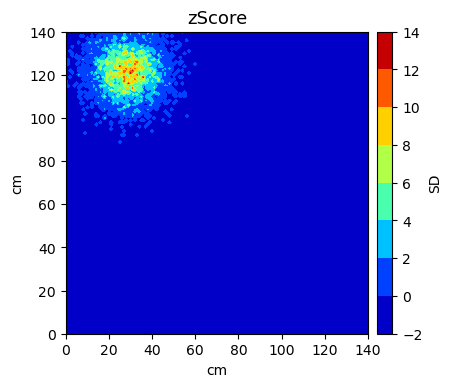

In [36]:
plotDataCell(data= masterZscore, index= 0, title= "zScore", units= "cm", colorbarLabel= "SD")

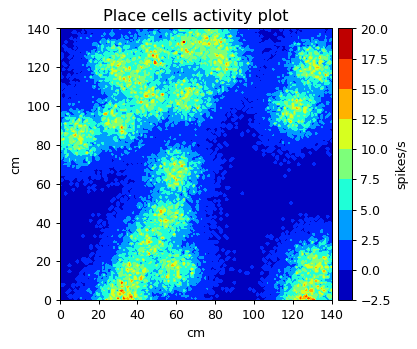

In [37]:
plotOrderedData(masterZscore)

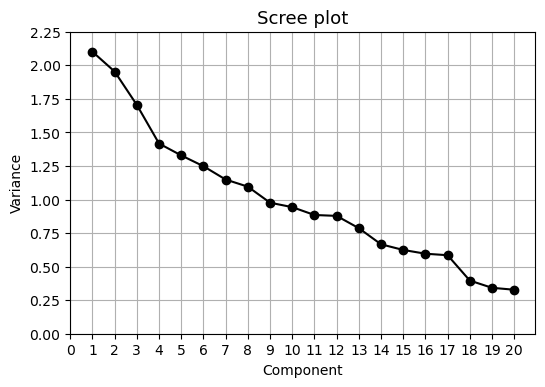

In [38]:
def plotVariance(variance):
    '''
    Plots variance (eigenvalues)
    Args:
        (numpy array of floats) : Vector of eigenvalues   ### look at the shape of the vector
    Returns:
        Nothing
    '''
    plt.figure(dpi=100, figsize=(6, 4))             # figsize=(?, 4)
    plt.clf()
    plt.plot(np.arange(1, len(variance) + 1), variance, 'o-k')

    # plt.loglog(np.arange(1, len(variance) + 1), variance, 'o-k')

    plt.title('Scree plot', size = 13)
    plt.xlabel('Component')
    plt.xticks(np.arange(0, len(variance)+1))                       ### is there a better way of doing this
    plt.ylabel('Variance')                                          ### eigenvalues
    plt.yticks(np.arange(0, max(variance)+0.25, step=0.25))

    plt.grid()

    plt.show()
    
    pass

plotVariance(masterMousePCA.explained_variance_)

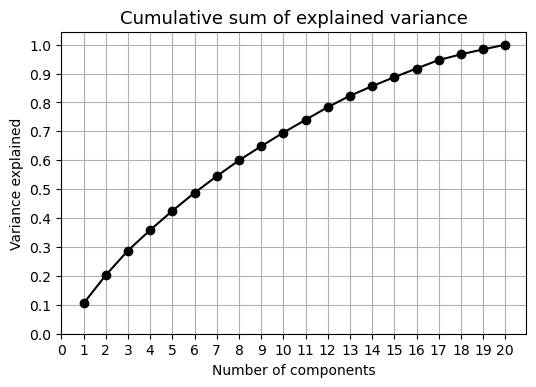

In [39]:
def plotVarianceExplained(explainedVariance):
    """
    Plots explained variance ratio
    Args:
        explainedVarianceRatio (numpy array of floats) : Vector of variance explained
                                                         for each PC
    Returns:
        Nothing.
    """
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, 'o-k')

    plt.title('Cumulative sum of explained variance', size = 13)

    plt.xlabel('Number of components')
    plt.xticks(np.arange(0, len(explainedVariance)+1))                  ### is there a better way of doing this
    plt.ylabel('Variance explained')
    plt.yticks(np.arange(0, max(explainedVariance)+0.05, step=0.1))

    plt.grid()

    plt.show()

    pass

masterExplainedVariance = np.cumsum(masterMousePCA.explained_variance_)/np.sum(masterMousePCA.explained_variance_)
plotVarianceExplained(masterExplainedVariance)

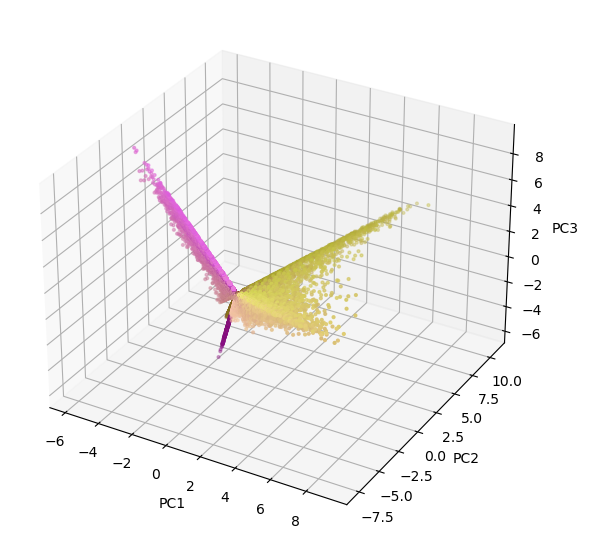

In [40]:
def plotThreeComponents(scores, location):
    '''
    plot first three components (latent variables) in 3D scatter plot

    Args:
        scores: latent variables matrix from PCA
    
    Returns:
    '''
    lv_1 = scores[:,0]
    lv_2 = scores[:,1]
    lv_3 = scores[:,2]

    ### this somehow makes the figure interactive. I don't understand this line
    # %matplotlib notebook
    ### it also seems to work when I comment it out

    colorMap = colormapLocation(location)

    plt.figure(dpi=100, figsize=(7,7))
    plt.clf()
    # plt.title('First three principal components scatter plot')

    ax = plt.axes(projection='3d')
    # ax.scatter3D(lv_1, lv_2, lv_3, s = 4)
    ax.scatter3D(lv_1, lv_2, lv_3, c= colorMap, s = 4)

    
    ## apparently works even without the 3D
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # ax.view_init(30,30)
    


    plt.show()

    
    pass

plotThreeComponents(masterScores,masterMouseDataLocation)

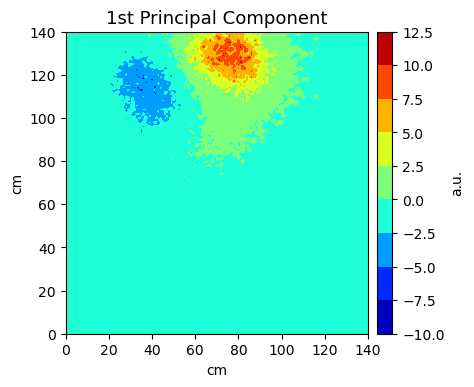

In [41]:
plotDataCell(data= masterScores, index= 1, title= "1st Principal Component", units= "cm", colorbarLabel= "a.u.")

### Data reconstruction

In [42]:
# # Master Scores by hand
# masterScoresHand = masterZscore @ masterWeights

# K = 100

# masterScoresHandCut = masterScoresHand[:, :K]
# masterWeightsCut = masterWeights[:, :K]
# ## scoresHandCut @ weightsCut.T

# dataRecon = masterScoresHandCut @ masterWeightsCut.T     #this should give me back approximation of masterZscore

# # plotDataCell(dataRecon, 0)

# plotOrderedData(dataRecon)

## MasterMouse ICA

In [43]:
masterICA = FastICA()
masterICA.fit(masterZscore)
masterICAdata = masterICA.transform(masterZscore)

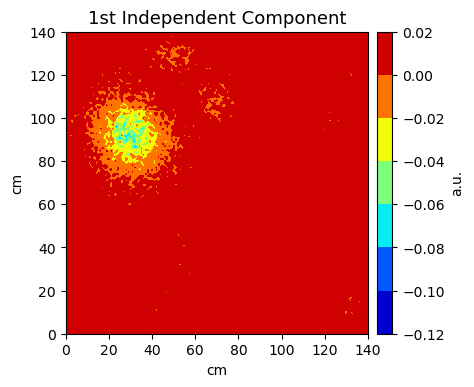

In [44]:
plotDataCell(data= masterICAdata, index= 0, title= "1st Independent Component", units= "cm", colorbarLabel= "a.u.")

# Random Mouse Data Exploration

In [45]:
# def skPCA(data):

randomZscore = zscore(randomMouseData)       # Importance of zscore? I believe zscore centres data, right?
randomZscore = np.nan_to_num(randomZscore)   # This is strange, how come it does not run without this
#  sk-learn: 'The input data is centered but not scaled for each feature before applying the SVD.'
#  z-score solves this, right?

# Number of components to keep. if n_components is not set all components are kept:
# n_components == min(n_samples, n_features)...
# ...Hence, the None case results in:
# n_components == min(n_samples, n_features) - 1

randomMousePCA = PCA()
randomMousePCA.fit(randomZscore)

randomWeights = randomMousePCA.components_                                     # eigenvectors ordered by eigenvalues
randomVariance = randomMousePCA.explained_variance_                            # eigenvalues
randomExplainedVariance = np.cumsum(randomVariance)/np.sum(randomVariance)
randomScores = randomMousePCA.transform(randomZscore)                          #latent variables

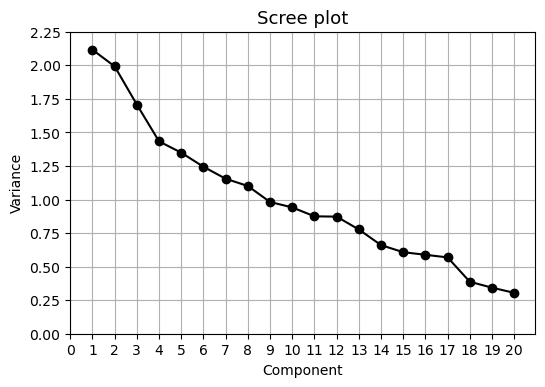

In [46]:
plotVariance(randomMousePCA.explained_variance_)

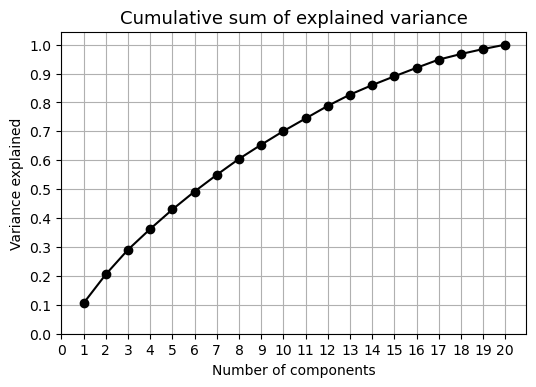

In [47]:
randomExplainedVariance = np.cumsum(randomMousePCA.explained_variance_)/np.sum(randomMousePCA.explained_variance_)
plotVarianceExplained(randomExplainedVariance)

## First 3 components in 3D

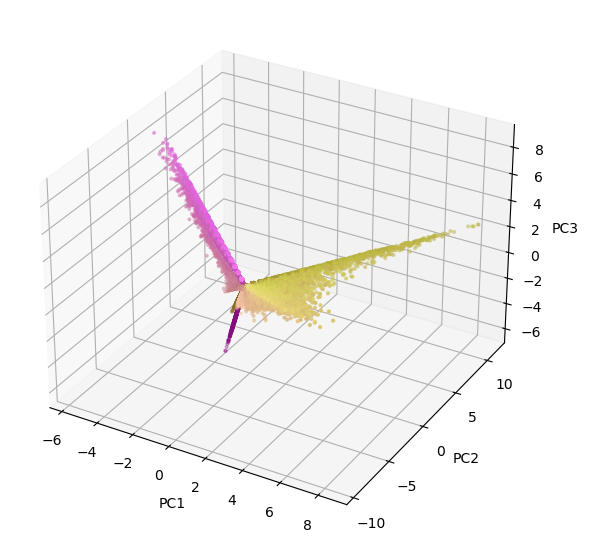

In [48]:
plotThreeComponents(randomScores, randomMouseDataLocation)

In [49]:
# K = 100

# masterScoresHandCut = masterScoresHand[:, :K]
# randomWeightsCut = randomWeights[:, :K]
# ## scoresHandCut @ weightsCut.T

# dataRecon = masterScoresHandCut @ randomWeightsCut.T     #this should give me back approximation of masterZscore

# plotDataCell(dataRecon, 15)

# # plotOrderedData(dataRecon)

## RandomMouse ICA

In [50]:
# randomICA = FastICA()
# randomICA.fit(randomZscore)
# randomICAdata = randomICA.transform(randomZscore)

In [51]:
# plotDataCell(randomICAdata, 0)
# plt.show()

# UMAP

In [52]:
# sns.pairplot(masterMouseData)

In [53]:
# def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
#     reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)

#     u = reducer.fit_transform(data)

#     fig = plt.figure()
    
#     if n_components == 1:
#         ax = fig.add_subplot(111)
#         ax.scatter(u[:,0], range(len(u)), c=data)
#     if n_components == 2:
#         ax = fig.add_subplot(111)
#         ax.scatter(u[:,0], u[:,1], c=data)
#     if n_components == 3:
#         ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
#     plt.title(title, fontsize=18)

In [54]:
# masterReducer = umap.UMAP()     # n_neighbors=
# masterEmbedding = masterReducer.fit_transform(masterZscore)

# print(masterEmbedding.shape)


In [55]:

# # plt.scatter(masterEmbedding[:, 0], masterEmbedding[:, 1])
# plt.figure(dpi=100)
# plt.scatter(masterEmbedding[:, 0], masterEmbedding[:, 1], c= colormapLocation(masterMouseDataLocation))

# plt.title("UMAP embedding", size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

In [56]:
randomReducer = umap.UMAP()     # n_neighbors=
randomEmbedding = randomReducer.fit_transform(randomZscore)

print(randomEmbedding.shape)

(19881, 2)


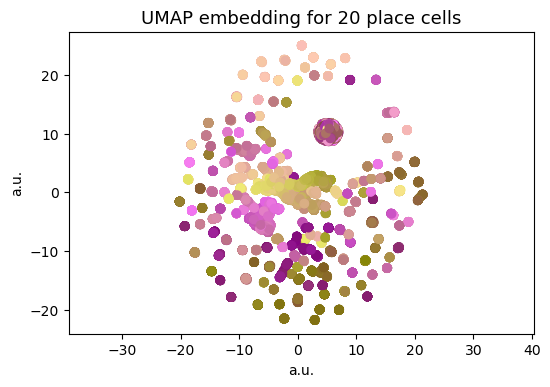

In [57]:
# plt.scatter(randomEmbedding[:, 0], randomEmbedding[:, 1])

plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(randomEmbedding[:, 0], randomEmbedding[:, 1], c= colormapLocation(randomMouseDataLocation))

plt.title("UMAP embedding for 20 place cells", size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [58]:
# visualize_components(randomEmbedding[:, 0], randomEmbedding[:, 1], colormapLocation(randomMouseDataLocation))

# Laplacian Eigenmaps (Spectral Embedding)

In [59]:
# masterLaplacian = SpectralEmbedding(n_components = 3)

# masterLaplacianEmbedding = masterLaplacian.fit_transform(masterMouseData)   # This takes very long time (15min for 100 neurons and 10201 sample points)
#                                                                             # 70 minutes minutes for 19881 sample points

In [60]:
# masterLaplacianEmbedding = np.load("masterLaplacianEmbedding_20n_run1.npy")
# masterMouseDataLocation = np.load("masterMouseDataLocation_20n_run1.npy")

In [61]:
# plt.figure(dpi=100)
# plt.scatter(masterLaplacianEmbedding[:, 0], masterLaplacianEmbedding[:, 1], c= colormapLocation(masterMouseDataLocation))

# plt.title("Laplacian embedding of 20 neurons", size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

In [62]:
# np.save("masterLaplacianEmbedding_20n_run1.npy", masterLaplacianEmbedding)
# np.save("masterMouseDataLocation_20n_run1.npy", masterMouseDataLocation)

In [63]:
# randomLaplacian = SpectralEmbedding(n_components = 3)

# randomLaplacianEmbedding = randomLaplacian.fit_transform(randomMouseData)       #This takes ages, ~1 hour for 19881 sample points

In [64]:
# randomLaplacianEmbedding = np.load("randomLaplacianEmbedding_20n_run1.npy")       # problem with dala location, have to save them too
# randomMouseDataLocation = np.load("randomMouseDataLocation_20n_run1.npy")

In [65]:
# plt.figure(dpi=100)
# plt.scatter(randomLaplacianEmbedding[:, 0], randomLaplacianEmbedding[:, 1], c= colormapLocation(randomMouseDataLocation))

# plt.title("Laplacian embedding of 20 neurons", size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')


In [66]:
# np.save("randomLaplacianEmbedding_20n_run1.npy", randomLaplacianEmbedding)
# np.save("randomMouseDataLocation_20n_run1.npy", randomMouseDataLocation)

# np.save("randomLaplacianEmbedding_100n_run1.npy", randomLaplacianEmbedding)
# np.save("randomMouseDataLocation_100n_run1.npy", randomMouseDataLocation)

## Room(s)

In [67]:
# class RectangularRoom(object):
#     '''
#     A RectangularRoom represents a rectangular region containing place cells
#     '''
#     def __init__(self, width, height):
#         '''
#         Initializes a rectangular room with the specified width and height.
#         No place cells at this point
#         '''
#         self.width = width
#         self.height = height
        
    

# ---------------------------------------------------------------------------------------------------------------

# Notes, tests, etc.

In [68]:
def randomMouse2(nSteps, cellsList, height = 5, width = 5):
    
    data = np.zeros(nSteps * len(cellsList))
    
    index = 0
    for i in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        ## here again I have to make sure height and width are in correct order
        
        for placeCell in cellsList:
            data[index] = placeCell.activity(location)
#             data[index] = placeCell.gaussian(location)
            index += 1
            
    return data

# nSteps = 10000

# %timeit randomMouse2(nSteps, cellsList, height = height, width = width)


In [69]:
# def randomMouse3(nSteps, cellsList, height = 5, width = 5):

#     data = np.zeros(nSteps * len(cellsList))
#     heights = np.random.uniform(0, height, size = (nSteps, ))
#     widths = np.random.uniform(0, width, size = (nSteps, ))
#     locations = np.hstack((heights, widths))

#     index = 0
#     for location in locations:
#         for placeCell in cellsList:
#             data[index] = placeCell.gaussian(location)
#             index += 1

#     return data

# %timeit randomMouse3(nSteps, cellsList, height = height, width = width)


In [70]:
### old plotting function

# def plotCells(height = 5, width = 5):

#     # bivariate normal distribution will be over variables X and Y
#     N = 100  #number on steps for each dimension. Used entirely for visualizing puposes.
#     x_coordinates = np.linspace(0, width, N)
#     y_coordinates = np.linspace(0, height, N)

#     X, Y = np.meshgrid(x_coordinates, y_coordinates)

#     Z = np.zeros((N, N))

#     for placeCell in cellsList:

#         for x in range(N):
#             for y in range(N):

#                 element = np.array([[x_coordinates[x]],
#                                     [y_coordinates[y]]])
#                 result = placeCell.gaussian(element)

#                 if Z[x][y] < result:
#                     Z[x][y] = result

#     fig = plt.figure("cells", dpi=90)
#     plt.clf()
#     plt.contourf(X, Y, Z, cmap = 'jet')
#     plt.colorbar()

#     plt.title("Place cells activity plot")

#     plt.show()
    
#     return fig
    
# fig1 = plotCells(height, width)


In [ ]:
# the drunkard's walk
# rewrite as function

class DrunkMouse(object):

    def __init__(self, cellsList = cellsList, height = height, width = width):
        
        self.cellsList = cellsList
        self.height = height
        self.width = width

        self.origin = np.array([[self.width /2],
                                [self.height /2]])

    def move(self, nSteps):

        cm = 1
        movements = [np.array([[cm],[0]]), np.array([[-cm],[0]]), np.array([[0],[cm]]), np.array([[0],[-cm]])]

        dataLocation = np.zeros((2,1))
        location = self.origin

        for step in range(nSteps):

            dataLocation = np.concatenate((dataLocation, location),axis=1)
            lastMove = random.choice(movements)
            location += lastMove

            while (location[0,0] < 0 or location[0,0] > width) or (location[1,0] < 0 or location[1,0] > height):
                location -= lastMove
                lastMove = random.choice(movements)
                location += lastMove

        dataLocation = np.delete(dataLocation,0,1)
        return dataLocation

In [71]:
# import multiprocessing as mp

# def cellActivations(cellsList):

#     location = np.array([[random.uniform(0,height)],
#                          [random.uniform(0,width)]])
    
#     index = 0
#     for placeCell in cellsList:
#         sample = np.zeros((1,20))
#         locationActivity = placeCell.gaussian(location)
#         sample[0, index] = locationActivity
#         index += 1œ
    
#     return sample


# with mp.Pool(processes = mp.cpu_count()) as pool:
    
#     data = pool.map(cellActivations, [cellsList for i in range(nSteps)])






In [72]:
def plotThreeComponents(scores, location):
    '''
    plot first three components (latent variables) in 3D scatter plot

    Args:
        scores: latent variables matrix from PCA
    
    Returns:
    '''
    lv_1 = scores[:,0]  # xData
    lv_2 = scores[:,1]  # yData
    lv_3 = scores[:,2]  # zData

    # normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    # normalizeY = clrs.Normalize(vmin = 0, vmax = height)

    # normX = normalizeX(location[0,:])
    # normY = normalizeY(location[1,:])

    # mapX = clrs.Colormap(cm.Blues)
    # mapY = clrs.Colormap(cm.Greens)

    # mapX(normX)
    # mapY(normY)

    # location = np.stack((mapX(normX),mapY(normY)))

    location_X, location_Y =  colormapLocation(location)

    map = location_X/2 + location_Y/2

    map = masterMouseColorLocation

    ### this somehow makes the figure interactive. I don't understand this line
    # %matplotlib notebook
    ### it also seems to work when I comment it out

    fig = plt.figure(dpi=90, figsize=(7,7))
    plt.clf()

    ax = plt.axes(projection='3d')
    ax.scatter3D(lv_1, lv_2, lv_3, c=map, s = 4, cmap = cm.coolwarm)
    # ax.scatter(lv_1, lv_2, lv_3, c=colorList, s=4, cmap = cm.coolwarm)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # ax.view_init(30,30)

    plt.show()
    
    pass

plotThreeComponents(masterScores, masterMouseDataLocation)

ValueError: too many values to unpack (expected 2)

In [ ]:
Blues = cm.get_cmap('Blues')

In [ ]:
#### colormaping the data #### - 

def colormapLocation(location, width = width, height = height):
    
    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)

    normX = normalizeX(location[0,:])
    normY = normalizeY(location[1,:])

    # mapX = clrs.Colormap('Blues')
    # mapY = clrs.Colormap('Reds')       ## this was causing major issues

    mapX = cm.get_cmap('Blues')
    mapY = cm.get_cmap('Oranges')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)

    return (colorValues_X, colorValues_Y)

In [ ]:
location = masterMouseDataLocation

normalizeX = clrs.Normalize(vmin = 0, vmax = width)
normalizeY = clrs.Normalize(vmin = 0, vmax = height)

normX = normalizeX(location[0,:])
normY = normalizeY(location[1,:])

# mapX = clrs.Colormap('Blues')
mapX = clrs.Colormap("Blues")
mapY = clrs.Colormap("Oranges")

print(type(normX))
print(normX)

something = np.array([0.2,0.4,0.6,0.8])

mapX(0.5)
# foo = mapX(normX)
# foobar = mapY(normY)

# print(normX)
# print(normY)


In [ ]:
randomMouseDataLocation[:,:10]

In [ ]:
### COLORMAP PROBLEM

import numpy as np
import matplotlib.colors as clrs
from matplotlib import cm


location = np.array([[0.72, 1.69, 4.85, 1.20, 0.45, 2.13, 3.65 , 4.03, 3.27, 4.59],
                     [4.02, 3.73, 2.95, 0.22, 1.81, 0.45, 3.30, 4.54, 2.74, 1.14]])

normalizeX = clrs.Normalize(vmin = 0, vmax = 5)
normalizeY = clrs.Normalize(vmin = 0, vmax = 5)

normX = normalizeX(location[0,:])
normY = normalizeY(location[1,:])

# mapX = clrs.Colormap('Blues')
# mapY = clrs.Colormap('Greens')       ## this was causing major issues

mapX = cm.get_cmap('Blues')
mapY = cm.get_cmap('Greens')

colorValues_X = mapX(normX)
colorValues_Y = mapY(normY)

In [ ]:
colorValues_X.shape

In [ ]:
x_coordinates = np.arange(start=0, stop= width +0.05, step=0.05)
y_coordinates = np.arange(start=0, stop= height +0.05, step=0.05)

In [ ]:
coordinates = np.array((x_coordinates, y_coordinates))

In [ ]:
coordinates

In [ ]:
d1 = np.arange(9).reshape(3,3)
d2 = np.arange(9,18).reshape(3,3)


In [ ]:
foo = np.stack((d1,d2))

print(foo.shape)
print("#######")
print(foo)
print("#######")
print(foo[0,:,:])

(2, 3, 3)
#######
[[[ 0  1  2]
  [ 3  4  5]
  [ 6  7  8]]

 [[ 9 10 11]
  [12 13 14]
  [15 16 17]]]
#######
[[0 1 2]
 [3 4 5]
 [6 7 8]]


In [ ]:
d3 = np.arange(18,27).reshape(3,3)
print(d3)

np.vstack((foo, d3[None]))

[[18 19 20]
 [21 22 23]
 [24 25 26]]


array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [ ]:
x = np.zeros((2,3,4))
x

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])